In [1]:
#Import the required libraries
from pandas_datareader import data as web
import pandas as pd
import yfinance as yf  #added this library to fix cell 7
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
### Get number of stocks, and tickers from user, check that the ticker is valid
def get_valid_stock(prompt):
    while True:
        stock = input(prompt).upper()
        ticker = yf.Ticker(stock)
        try:
            # Check if we can retrieve any basic info (e.g., name) to verify it's valid
            if ticker.info and 'shortName' in ticker.info:
                return stock
            else:
                print(f"{stock} is not a valid ticker. Please try again.")
        except Exception as e:
            print(f"Error retrieving data for {stock}. Please try again.")

# Ask the user for the number of stocks they want to enter
num_stocks = int(input("How many stocks would you like to enter?\n"))

# Collect valid stock tickers based on the chosen number
assets = []
for i in range(num_stocks):
    stock = get_valid_stock(f"What is the stock ticker for stock #{i+1}?\n")
    assets.append(stock)

print("Validated assets:", assets)

How many stocks would you like to enter?
 3
What is the stock ticker for stock #1?
 AAPL
What is the stock ticker for stock #2?
 META
What is the stock ticker for stock #3?
 GOOG


Validated assets: ['AAPL', 'META', 'GOOG']


In [3]:
# Function to get weights from the user and ensure they sum to 1
def get_weights(num_stocks):
    weights = []
    for i in range(num_stocks):
        while True:
            try:
                weight = float(input(f"Enter the weight for stock #{i+1} (in decimal form, e.g., 0.2 for 20%): "))
                if 0 <= weight <= 1:
                    weights.append(weight)
                    break
                else:
                    print("Please enter a weight between 0 and 1.")
            except ValueError:
                print("Invalid input. Please enter a decimal number.")

    # Check if weights sum to 1
    if sum(weights) != 1:
        print("The weights you entered do not sum to 1. Please try again.")
        return get_weights(num_stocks)  # Restart if sum is incorrect
    return np.array(weights)

# Get weights from the user
weights = get_weights(num_stocks)
print("Assigned weights:", weights)

Enter the weight for stock #1 (in decimal form, e.g., 0.2 for 20%):  0.5
Enter the weight for stock #2 (in decimal form, e.g., 0.2 for 20%):  0.2
Enter the weight for stock #3 (in decimal form, e.g., 0.2 for 20%):  0.3


Assigned weights: [0.5 0.2 0.3]


In [4]:
#Get the stock/portfolio start date
stockStartDate = datetime(2013, 1, 1)
today = datetime.today().strftime("%Y-%m-%d")
today

'2025-02-25'

In [6]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Fetch stock data with error handling
for stock in assets:
    try:
        # Download stock data from Yahoo Finance
        data = yf.download(stock, start=stockStartDate, end=today)
        
        # Check if the 'Close' column exists (as 'Adj Close' is missing)
        if 'Close' in data.columns:
            # Access the 'Close' column for each stock and add it to the DataFrame
            df[stock] = data['Close']
        else:
            print(f"Missing 'Close' for {stock}. Available columns: {data.columns}")
    
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")

# Output the DataFrame with close prices
print(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  AAPL        META        GOOG
Date                                          
2013-01-02   16.669018   27.893450   17.949236
2013-01-03   16.458614   27.664324   17.959660
2013-01-04   16.000160   28.650557   18.314550
2013-01-07   15.906043   29.308046   18.234638
2013-01-08   15.948853   28.949413   18.198652
...                ...         ...         ...
2025-02-18  244.470001  716.369995  185.800003
2025-02-19  244.869995  703.770020  187.130005
2025-02-20  245.830002  694.840027  186.639999
2025-02-21  245.550003  683.549988  181.580002
2025-02-24  247.100006  668.130005  181.190002

[3055 rows x 3 columns]


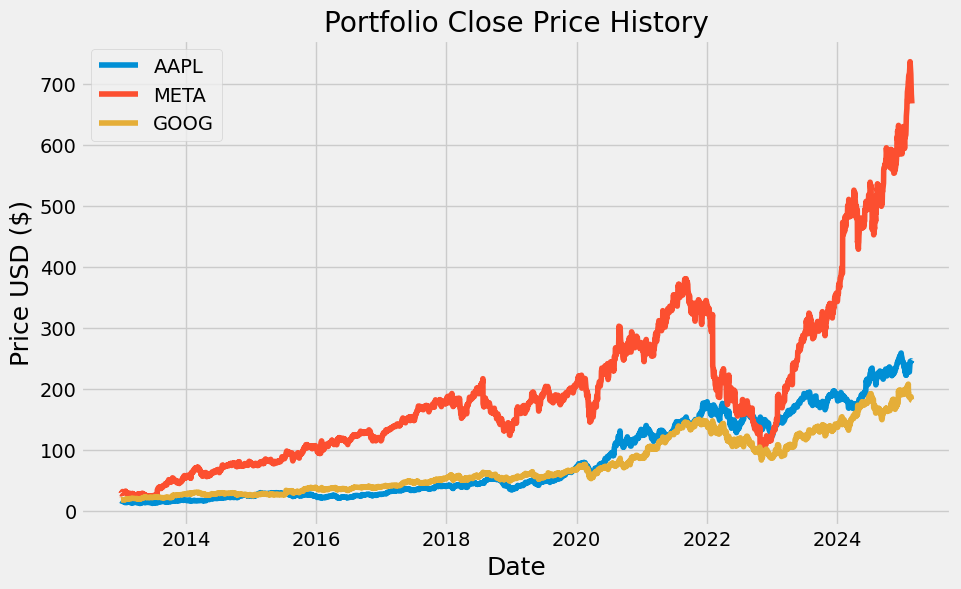

In [7]:
#Plot the close price history
title = "Portfolio Close Price History"
my_stocks = df

plt.figure(figsize=(10, 6))
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label=c)

plt.title(title)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()

In [8]:
#show the daily simple return
returns = df.pct_change()
returns

,AAPL,META,GOOG
Date,,,
2013-01-02,NaN,NaN,NaN
2013-01-03,-0.012622,-0.008214,0.000581
2013-01-04,-0.027855,0.035650,0.019760
2013-01-07,-0.005882,0.022949,-0.004363
2013-01-08,0.002691,-0.012237,-0.001973
...,...,...,...
2025-02-18,-0.000531,-0.027556,-0.005726
2025-02-19,0.001636,-0.017589,0.007158
2025-02-20,0.003920,-0.012689,-0.002619


In [9]:
#create and show anualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,AAPL,META,GOOG
AAPL,0.078101,0.049107,0.041878
META,0.049107,0.144676,0.060312
GOOG,0.041878,0.060312,0.075669


In [10]:
#calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.061744653619764854

In [11]:
#Calculate the portfolio volitility
port_volatility = np.sqrt(port_variance)
port_volatility

0.24848471506264697

In [12]:
#calculate the annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.266306420413132

In [13]:
#Show the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2) * 100) + '%'

print("Expected annual return: " + percent_ret)
print("Annual Volatility / risk: " + percent_vols)
print("Annual Variance: " + percent_var)

Expected annual return: 27.0%
Annual Volatility / risk: 25.0%
Annual Variance: 6.0%


In [14]:
#!pip install PyPortfolioOpt

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [16]:
#Portfolio Optimization

#Calculate expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

#Optimize for max Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict({'AAPL': 0.54042, 'META': 0.25955, 'GOOG': 0.20002})
Expected annual return: 25.4%
Annual volatility: 25.4%
Sharpe Ratio: 1.00


(0.2544677899362765, 0.25431555467856976, 1.0005986077332123)

In [19]:
#Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights

# Ask the user for the total portfolio value
try:
    total_portfolio_value = float(input("Enter the amount of money you want to invest in your portfolio: $"))
except ValueError:
    print("Invalid input! Please enter a numeric value.")
    exit()

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Enter the amount of money you want to invest in your portfolio: $ 10000


Discrete allocation: {'AAPL': 22, 'META': 4, 'GOOG': 10}
Funds remaining: $79.38


In [20]:
#This code block adds optimization for sorintino ratio

from scipy.optimize import minimize

# Set parameters
risk_free_rate = 0.01  # Adjust as per the current risk-free rate

# Define the Sortino Ratio calculation function
def sortino_ratio(weights, returns, risk_free_rate=0.01):
    portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualized return
    downside_returns = returns[returns < 0].fillna(0)  # Only consider negative returns
    downside_risk = np.sqrt(np.mean((downside_returns.dot(weights)) ** 2)) * np.sqrt(252)  # Annualized downside risk

    sortino = (portfolio_return - risk_free_rate) / downside_risk
    return -sortino  # Negative for minimization

# Constraints: weights sum to 1
def weight_constraint(weights):
    return np.sum(weights) - 1


# Convert the 'weights' OrderedDict to a list for optimization
initial_weights = list(weights.values())
# bounds should have the same length as initial_weights
bounds = [(0, 1) for _ in range(len(initial_weights))]


# Run the optimization
# Change: Pass initial_weights instead of weights to minimize
optimized_result = minimize(
    sortino_ratio,
    initial_weights,  # Pass the list of initial weights here
    args=(returns, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints={'type': 'eq', 'fun': weight_constraint}
)

# Extract optimized weights
optimized_weights = optimized_result.x
optimized_sortino = -optimized_result.fun  # Get positive Sortino Ratio

print("Optimized Portfolio Weights:", optimized_weights)
print("Maximized Sortino Ratio:", optimized_sortino)

Optimized Portfolio Weights: [0.52378282 0.35109621 0.12512097]
Maximized Sortino Ratio: 1.462054641272111


In [21]:
#Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)

# Convert optimized_weights (NumPy array) to a dictionary
weights = dict(zip(df.columns, optimized_weights)) # df.columns provides the tickers

# Ask the user for the total portfolio value
try:
    total_portfolio_value = float(input("Enter the amount of money you want to invest in your portfolio: $"))
except ValueError:
    print("Invalid input! Please enter a numeric value.")
    exit()

# Pass optimized_weights to DiscreteAllocation
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Enter the amount of money you want to invest in your portfolio: $ 10000


Discrete allocation: {'AAPL': 21, 'META': 5, 'GOOG': 7}
Funds remaining: $201.92
